In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt

% matplotlib inline

import sys
sys.path.append("..")

In [2]:
import rascals

rascals.setupOorb()
config = rascals.Config()

In [3]:
DATABASE = "../data/objects.db"
con = sql.connect(DATABASE)

#### Cell and Query Code

In [4]:
class Cell:
    
    def __init__(self, x, y, radius, night):
        self.center = np.array([x, y])
        self.radius = radius
        self.night = night
        self.observations = None
        self.xRange = [x - radius, x + radius]
        self.yRange = [y - radius, y + radius]
        
    def gatherObservations(self,
                           con,
                           queryType="truth",
                           observationColumns=config.observationColumns,
                           truthColumns=config.truthColumns):
        self.observations = queryCell(con,
                                      self,
                                      queryType=queryType,
                                      observationColumns=observationColumns,
                                      truthColumns=truthColumns)
        print("Found {} observations.".format(len(self.observations)))
    

def createQuery(queryType,
                observationColumns=config.observationColumns,
                truthColumns=config.truthColumns):
    if queryType == "observation":
        columns = list(config.observationColumns.values())
    elif queryType == "truth":
        columns = list(config.observationColumns.values()) + list(config.truthColumns.values())
    else:
        raise ValueError("queryType should be one of 'observation' or 'truth'")
    query = '"' + '", "'.join(columns) + '"'
    return query

def queryNight(con,
               night,
               queryType="observation",
               observationColumns=config.observationColumns,
               truthColumns=config.truthColumns):
    
    query = createQuery(queryType,
                        observationColumns=observationColumns,
                        truthColumns=truthColumns)
    night_df = pd.read_sql("""SELECT {} FROM ephemeris
                              WHERE night = {}""".format(query, night), con)
    columnMapping = {**observationColumns, **truthColumns}
    inverseMapping = {value : key for key, value in columnMapping.items()}
    night_df.rename(columns=inverseMapping, inplace=True)
    return night_df

def queryCell(con,
              cell,
              queryType="observation",
              observationColumns=config.observationColumns,
              truthColumns=config.truthColumns):

    query = createQuery(queryType,
                        observationColumns=observationColumns,
                        truthColumns=truthColumns)
    
    cell_df = pd.read_sql("""SELECT {0} FROM ephemeris
                             WHERE (night = {1}
                             AND ({2} >= {3} AND {2} <= {4})
                             AND ({5} >= {6} AND {5} <= {7}))""".format(query,
                                                                        cell.night,
                                                                        observationColumns["RA_deg"],
                                                                        *cell.xRange,
                                                                        observationColumns["Dec_deg"],
                                                                        *cell.yRange), con)
    columnMapping = {**observationColumns, **truthColumns}
    inverseMapping = {value : key for key, value in columnMapping.items()}
    cell_df.rename(columns=inverseMapping, inplace=True)                                                                    

    keep = rascals.findObsInCell(cell_df["obs_id"].values,
                                 cell_df[["RA_deg", "Dec_deg"]].as_matrix(),
                                 cell.center,
                                 cell.radius)
    cell_df = cell_df[cell_df["obs_id"].isin(keep)]
    return cell_df


#### Plotting Code

In [5]:
def _setAxes(ax, coordinateSystem):
    """
    Helper function to set axes limits depending on the coordinate system.
    
    """
    if coordinateSystem == "equatorialAngular":
        ax.set_xlabel(r"$\alpha$ [deg]")
        ax.set_ylabel(r"$\delta$ [deg]")
    elif coordinateSystem == "eclipticAngular":
        ax.set_xlabel(r"$\lambda$ [deg]")
        ax.set_ylabel(r"$\beta$ [deg]")
    elif coordinateSystem == "gnomonic":
        ax.set_xlabel(r"$\theta_X$ [deg]")
        ax.set_ylabel(r"$\theta_Y$ [deg]")
    else:
        raise ValueError("coordinateSystem should be one of: 'equatorialAngular', 'eclipticAngular', 'tangentPlane'")

def plotCell(cell,
             coordinateSystem="equatorialAngular",
             scatterKwargs={"s":0.05}):
        
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = cell.observations["RA_deg"].values, 
        y = cell.observations["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = cell.observationst["lon_deg"].values, 
        y = cell.observations["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    ax.set_xlim(*cell.xRange)
    ax.set_ylim(*cell.yRange)
    
    cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
    ax.add_artist(cell_p)
    ax.grid()
    return
    
def plotNight(night,
              cell=None,
              coordinateSystem="equatorialAngular",
              scatterKwargs={"s":0.05},
              scatterXlims=(0, 360),
              scatterYlims=(-90, 90)):
    
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = night["RA_deg"].values, 
        y = night["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = night["lon_deg"].values, 
        y = night["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    ax.set_xlim(scatterXlims)
    ax.set_ylim(scatterYlims)

    if cell is not None:
        cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
        ax.add_artist(cell_p)

    ax.grid()
    return

In [6]:
night = queryNight(con, 59582)

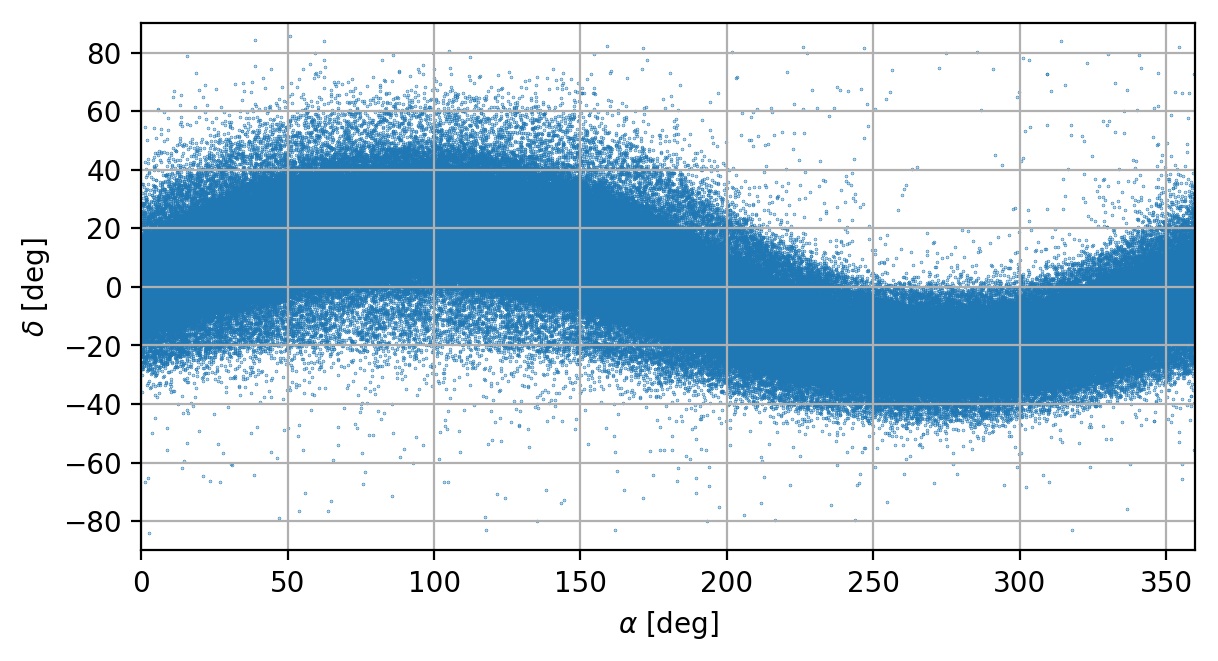

In [7]:
plotNight(night)

In [8]:
cell = Cell(199.8, -19.8, 1.0, 59582)

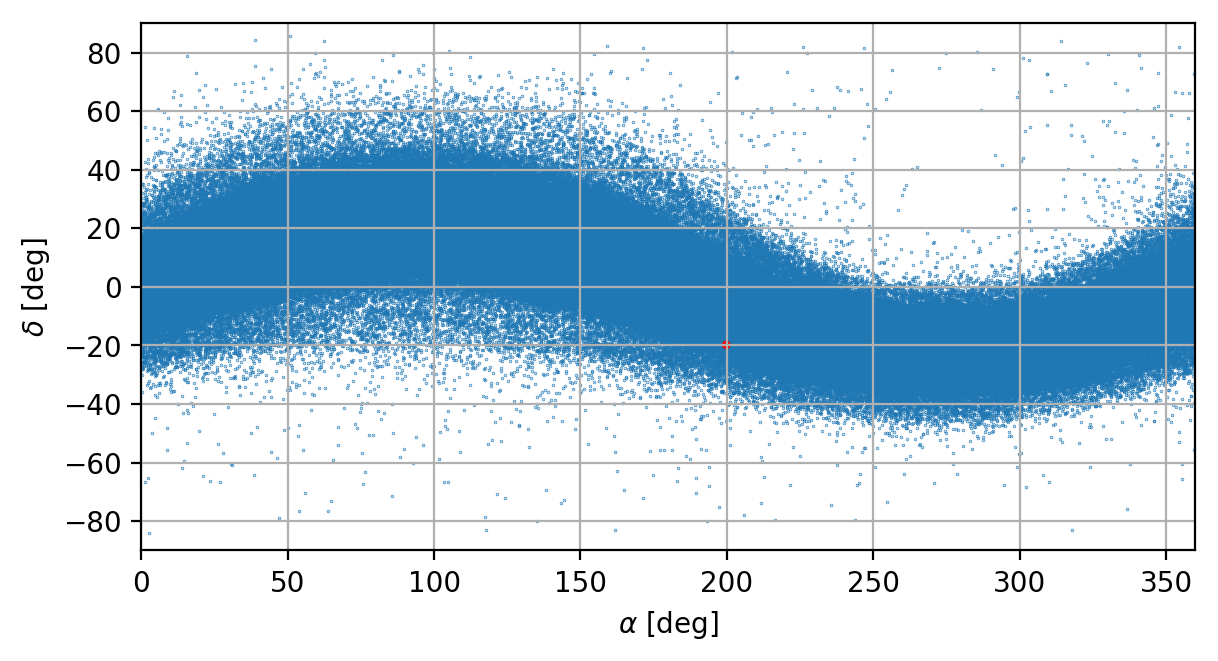

In [9]:
plotNight(night, cell=cell)

Found 81 observations.


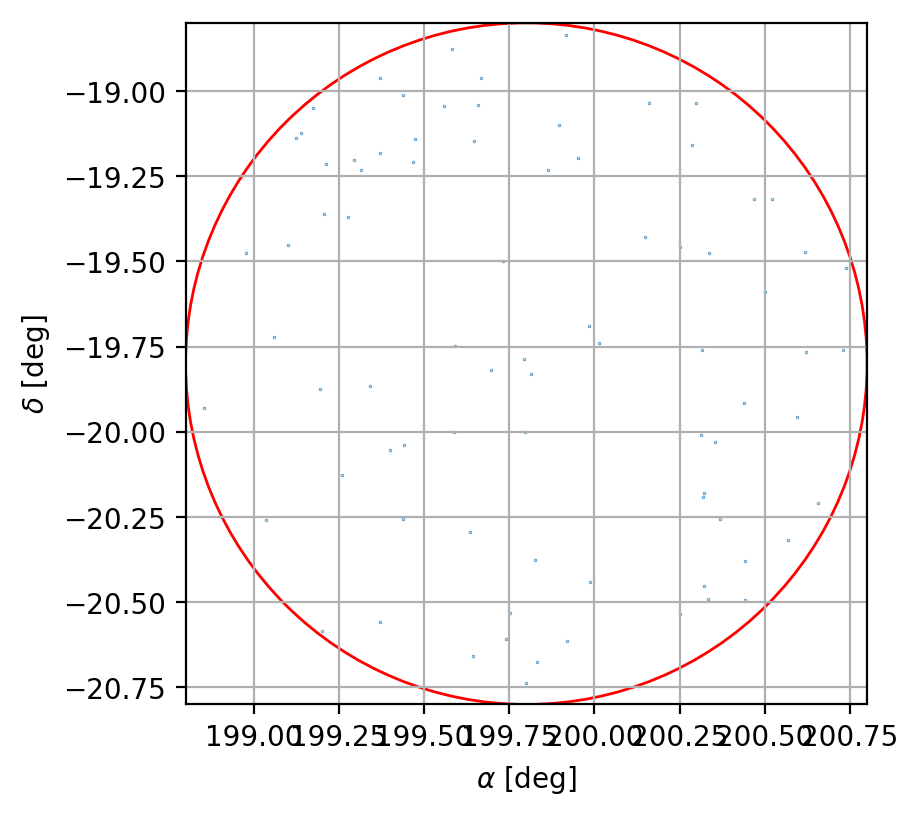

In [10]:
cell.gatherObservations(con)
plotCell(cell)

#### Guessing Barycentric Distance

In [23]:
cell.observations

,obs_id,exp_mjd,night,RA_deg,Dec_deg,obs_x_au,obs_y_au,obs_z_au,mag,name,Delta_au,r_au,obj_x_au,obj_y_au,obj_z_au,obj_dx/dt_au_p_day,obj_dy/dt_au_p_day,obj_dz/dt_au_p_day
0,454339,59582.173,59582,198.976384,-19.475951,-0.211947,0.960252,-0.000078,19.308037,14657,3.346568,3.281950,-3.195559,-0.424886,-0.615684,0.002381,-0.007971,-0.000084
1,789449,59582.173,59582,199.667763,-18.960455,-0.211947,0.960252,-0.000078,19.417335,25467,3.097795,3.037517,-2.970746,-0.344795,-0.531318,0.000080,-0.009026,-0.000437
2,1139935,59582.173,59582,200.568024,-20.318549,-0.211947,0.960252,-0.000078,19.936440,36773,2.576540,2.526931,-2.474146,-0.174448,-0.483268,0.002511,-0.010986,-0.000734
5,2298188,59582.173,59582,199.740178,-20.608807,-0.211947,0.960252,-0.000078,21.287442,74136,3.163244,3.088992,-2.998765,-0.400150,-0.623828,0.001141,-0.008765,0.000070
6,2352965,59582.173,59582,200.286241,-19.158899,-0.211947,0.960252,-0.000078,20.340407,75903,2.722082,2.673173,-2.623766,-0.213041,-0.465099,0.000283,-0.010375,-0.001340
7,2602732,59582.173,59582,200.440876,-20.494365,-0.211947,0.960252,-0.000078,20.436437,83960,3.125406,3.043127,-2.955195,-0.413081,-0.597334,0.003412,-0.008413,0.001887
9,3428138,59582.173,59582,199.275967,-19.370203,-0.211947,0.960252,-0.000078,20.754600,B0586,3.043382,2.989466,-2.922103,-0.310861,-0.549169,0.001351,-0.009401,0.000367
10,3568568,59582.173,59582,199.557962,-19.044788,-0.211947,0.960252,-0.000078,20.876386,B5116,3.504124,3.426625,-3.333159,-0.511910,-0.608077,0.001793,-0.008415,-0.000257
15,4630039,59582.173,59582,200.161126,-19.036095,-0.211947,0.960252,-0.000078,22.016827,E9357,2.628083,2.588221,-2.544086,-0.166324,-0.445928,-0.000278,-0.010104,-0.000242
16,4978045,59582.173,59582,200.318017,-20.190004,-0.211947,0.960252,-0.000078,21.212972,G0583,2.781153,2.721988,-2.659797,-0.253135,-0.520213,0.003158,-0.009384,-0.000172


In [24]:
print("r [AU]:\n min: {}\n max: {}\n median: {}".format(cell.observations["r_au"].min(),
                                                        cell.observations["r_au"].max(),
                                                        cell.observations["r_au"].median()))

r [AU]:
 min: 1.8270287254
 max: 4.667717103399999
 median: 2.9000345029


In [25]:
# For now lets take the object which has the median barycentric distance, lets also grab its velocity
real_object = cell.observations[cell.observations["name"] == "U3160"]
real_object_velocity_ec_cart = real_object[["obj_dx/dt_au_p_day", "obj_dy/dt_au_p_day", "obj_dz/dt_au_p_day"]].as_matrix()[0]
real_object_x_e = real_object[["obs_x_au","obs_y_au", "obs_z_au"]].as_matrix()[0]
print(real_object_velocity_ec_cart)

[-0.00080995 -0.01203773 -0.00112666]


In [26]:
real_object

,obs_id,exp_mjd,night,RA_deg,Dec_deg,obs_x_au,obs_y_au,obs_z_au,mag,name,Delta_au,r_au,obj_x_au,obj_y_au,obj_z_au,obj_dx/dt_au_p_day,obj_dy/dt_au_p_day,obj_dz/dt_au_p_day
39,9397932,59582.173,59582,199.792117,-19.786006,-0.211947,0.960252,-0.000078,21.187089,U3160,2.323884,2.30956,-2.269464,-0.031994,-0.427292,-0.00081,-0.012038,-0.001127


In [27]:
# Please excuse the messy code. I'm still trying to figure out the best way to 
# OOP this part of rascals.

class TestParticle:
    def __init__(self, center, r, x_e, velocity_ec_cart):
        self.center = center
        self.r = r
        self.x_e = x_e
        self.velocity_ec_cart = velocity_ec_cart
        
        
    def rascalize(self, verbose=True):
        if verbose is True:
            print("Convering to ecliptic coordinates...")
        self.center_ec = rascals.coordinates.equatorialToEclipticAngular(np.radians([self.center]))
        
        if verbose is True:
            print("Calculating asteroid to observer unit vector...")
        self.n_ae = rascals.vectors.calcNae(self.center_ec[:, 0:2])
        
        if verbose is True:
            print("Calculating asteroid to observer distance assuming r = {} AU...".format(self.r))
        self.delta = rascals.vectors.calcDelta(self.r, self.x_e, self.n_ae)
        
        if verbose is True:
            print("Calculating asteroid to observer position vector...")
        self.x_ae = rascals.vectors.calcXae(self.delta, self.n_ae)
        
        if verbose is True:
            print("Calculating barycentic asteroid position vector...")
        self.x_a = rascals.vectors.calcXa(self.x_ae, self.x_e)
        
        if verbose is True:
            print("Calculating R1 rotation matrix...")
        self.R1 = rascals.vectors.calcR1(self.x_a)
        self.x_a_xy = np.array(self.R1 @ self.x_a)[0]
        
        if verbose is True:
            print("Calculating R2 rotation matrix...")
        self.R2 = rascals.vectors.calcR2(self.x_a_xy)
        
        if verbose is True:
            print("Calculating final rotation matrix...")
        self.M = self.R2 @ self.R1
        
        if verbose is True:
            print("Done.")
        return
        
    def apply(self, cell, verbose=True):
        
        if verbose is True:
            print("Convering to ecliptic coordinates...")
        cell.coords_ec = rascals.coordinates.equatorialToEclipticAngular(np.radians(cell.observations[["RA_deg", "Dec_deg"]].as_matrix()))
        
        if verbose is True:
            print("Calculating asteroid to observer unit vector...")
        cell.n_ae = rascals.vectors.calcNae(cell.coords_ec)
        cell.x_e = cell.observations[["obs_x_au", "obs_y_au", "obs_z_au"]].as_matrix()
        
        if verbose is True:
            print("Calculating asteroid to observer distance assuming r = {} AU...".format(self.r))
        cell.delta = np.zeros(len(cell.n_ae))
        for i, (n_ae_i, x_e_i) in enumerate(zip(cell.n_ae, cell.x_e)):
            cell.delta[i] = rascals.vectors.calcDelta(self.r, x_e_i, n_ae_i)
        
        if verbose is True:
            print("Calculating asteroid to observer position vector...")
        cell.x_ae = np.zeros([len(cell.delta), 3])
        for i, (delta_i, n_ae_i) in enumerate(zip(cell.delta, cell.n_ae)):
            cell.x_ae[i] = rascals.vectors.calcXae(delta_i, n_ae_i)
        
        if verbose is True:
            print("Calculating barycentic asteroid position vector...")
        cell.x_a = np.zeros([len(cell.x_ae), 3])
        for i, (x_ae_i, x_e_i) in enumerate(zip(cell.x_ae, cell.x_e)):
            cell.x_a[i] = rascals.vectors.calcXa(x_ae_i, x_e_i)
        
        if verbose is True:
            print("Applying rotation matrix M to barycentric asteroid position vector...")
        cell.coords_cart_rotated = np.array(self.M @ cell.x_a.T).T
        
        if verbose is True:
            print("Performing gnomonic projection...")
        cell.gnomonic = rascals.projections.cartesianToGnomonic(cell.coords_cart_rotated)
        
        if verbose is True:
            print("Done.")
        return 

In [28]:
def phaseFold(center, radius, night, r, velocity_ec_cart, x_e, nightEnd, step=1.0, verbose=True):
    
    cells = []
    particles = []
    
    cell = Cell(*center, radius, night)
    cell.gatherObservations(con)

    particle = TestParticle(cell.center,
                            r,
                            x_e,
                            velocity_ec_cart)
    particle.rascalize(verbose=verbose)
    particle.apply(cell, verbose=verbose)
    
    cells.append(cell)
    particles.append(particle)
    
    for night_i in np.arange(night + step, nightEnd, step):
        
        propagated = rascals.propagateTestParticle(particle.x_a,
                                                   particle.velocity_ec_cart,
                                                   cell.observations["exp_mjd"].median(),
                                                   cell.observations["exp_mjd"].median() + step)
        
        cell = Cell(propagated["RA_deg"].values[0], propagated["Dec_deg"].values[0], radius, night_i)                            
        cell.gatherObservations(con)

        particle = TestParticle(cell.center,
                                r,
                                propagated[["HEclObsy_X_au","HEclObsy_Y_au", "HEclObsy_Z_au"]].as_matrix()[0],
                                propagated[["HEclObj_dX/dt_au_p_day", "HEclObj_dY/dt_au_p_day", "HEclObj_dZ/dt_au_p_day"]].as_matrix()[0])
        particle.rascalize(verbose=verbose)
        particle.apply(cell, verbose=verbose)

        cells.append(cell)
        particles.append(particle)
        
    return particles, cells

    

In [32]:
particles, cells = phaseFold(cell.center, cell.radius, cell.night, real_object["r_au"].values[0], real_object_velocity_ec_cart, real_object_x_e, cell.night + 9)

Found 81 observations.
Convering to ecliptic coordinates...
Calculating asteroid to observer unit vector...
Calculating asteroid to observer distance assuming r = 2.3095600726 AU...
Calculating asteroid to observer position vector...
Calculating barycentic asteroid position vector...
Calculating R1 rotation matrix...
Calculating R2 rotation matrix...
Calculating final rotation matrix...
Done.
Convering to ecliptic coordinates...
Calculating asteroid to observer unit vector...
Calculating asteroid to observer distance assuming r = 2.3095600726 AU...
Calculating asteroid to observer position vector...
Calculating barycentic asteroid position vector...
Applying rotation matrix M to barycentric asteroid position vector...
Performing gnomonic projection...
Done.
          RaSCaL -0.22693730857101E+01 -0.32499082061734E-01 -0.42773512419247E+00 -0.80995370000000E-03 -0.12037727400000E-01 -0.11266649000000E-02   59582.17300000  10.00000  0.150000
Propagating test particle from 59582.172999999

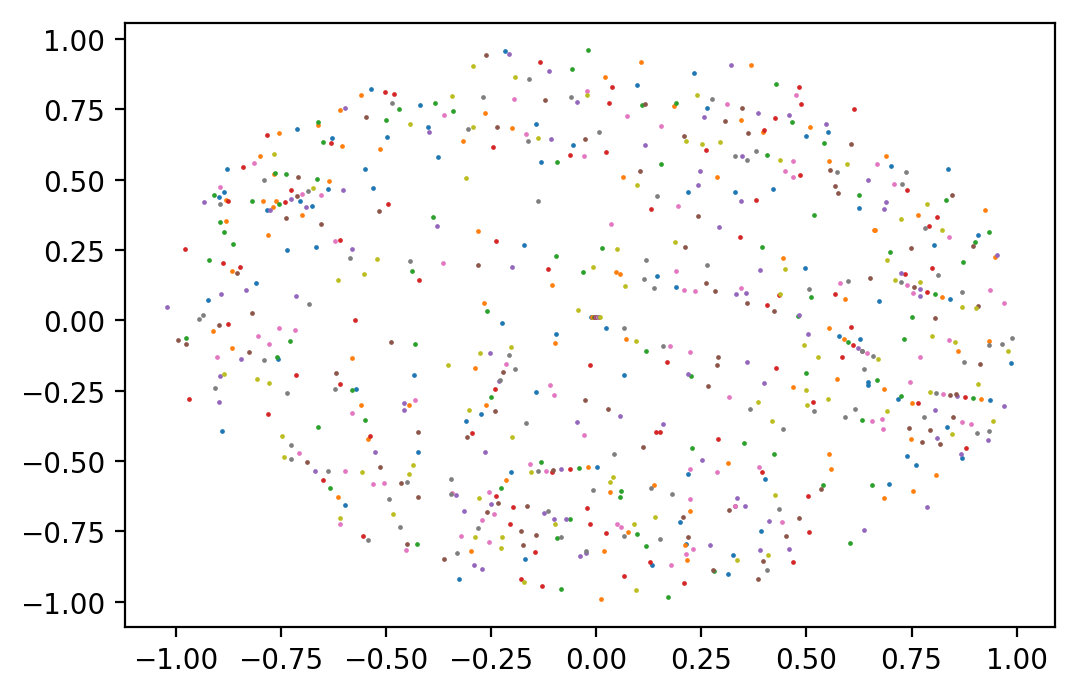

In [33]:
fig, ax = plt.subplots(1, 1, dpi=200)

for c in cells:
    ax.scatter(*np.degrees(c.gnomonic.T), s=0.5)

In [34]:
fig.savefig("10dayphasefold_correct_r&v.png")

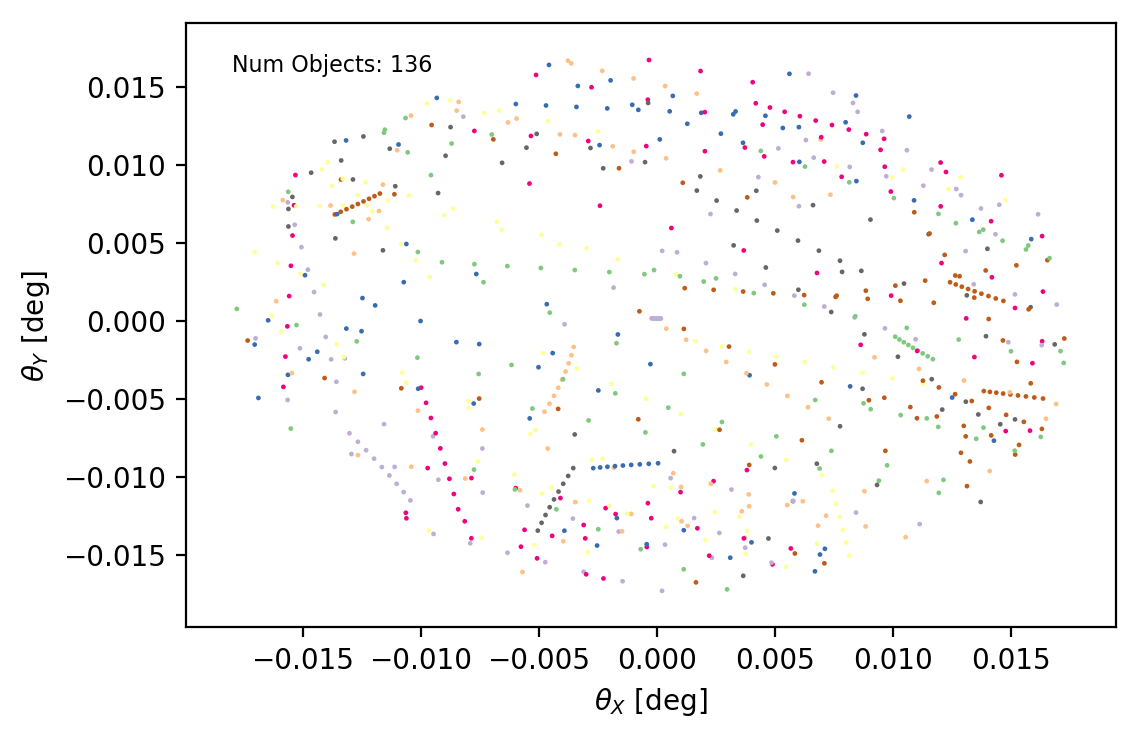

In [120]:
df = pd.DataFrame()
for c in cells:
    c.observations["theta_x"] = c.gnomonic[:,0]
    c.observations["theta_y"] = c.gnomonic[:,1]
    df = pd.concat([df, c.observations])
    
a, b = np.unique(df["name"].values, return_inverse=True)
hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())

fig, ax = plt.subplots(1, 1, dpi=200)
ax = df.plot(x="theta_x", y="theta_y", kind="scatter", c=hex_map[b], s=0.5, ax=ax)
_setAxes(ax, "gnomonic")
ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
#fig.savefig("10dayphasefold_correct_r&v_colorByObject.png")

In [121]:
particles2, cells2 = phaseFold(cell.center, cell.radius, cell.night, real_object["r_au"].values[0] + 0.5, real_object_velocity_ec_cart, real_object_x_e, cell.night + 9)

Found 81 observations.
Convering to ecliptic coordinates...
Calculating asteroid to observer unit vector...
Calculating asteroid to observer distance assuming r = 2.8095600726 AU...
Calculating asteroid to observer position vector...
Calculating barycentic asteroid position vector...
Calculating R1 rotation matrix...
Calculating R2 rotation matrix...
Calculating final rotation matrix...
Done.
Convering to ecliptic coordinates...
Calculating asteroid to observer unit vector...
Calculating asteroid to observer distance assuming r = 2.8095600726 AU...
Calculating asteroid to observer position vector...
Calculating barycentic asteroid position vector...
Applying rotation matrix M to barycentric asteroid position vector...
Performing gnomonic projection...
Done.
          RaSCaL -0.27471213587515E+01 -0.26302254798562E+00 -0.52704001849066E+00 -0.80995370000000E-03 -0.12037727400000E-01 -0.11266649000000E-02   59582.17300000  10.00000  0.150000
Propagating test particle from 59582.172999999

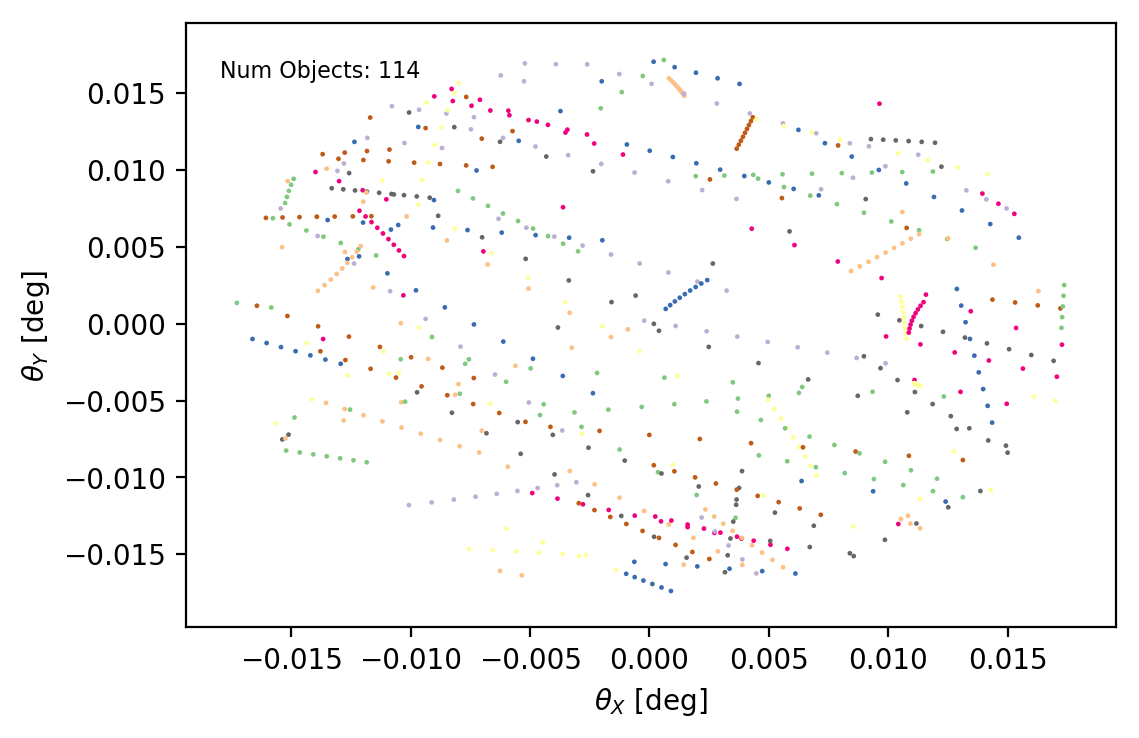

In [127]:
df = pd.DataFrame()
for c in cells2:
    c.observations["theta_x"] = c.gnomonic[:,0]
    c.observations["theta_y"] = c.gnomonic[:,1]
    df = pd.concat([df, c.observations])
    
a, b = np.unique(df["name"].values, return_inverse=True)
hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())

fig, ax = plt.subplots(1, 1, dpi=200)
ax = df.plot(x="theta_x", y="theta_y", kind="scatter", c=hex_map[b], s=0.5, ax=ax)
_setAxes(ax, "gnomonic")
ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
fig.savefig("10dayphasefold_incorrect_r+05_correct_v_colorByObject.png")

In [122]:
particles3, cells3 = phaseFold(cell.center, cell.radius, cell.night, real_object["r_au"].values[0] - 0.5, real_object_velocity_ec_cart, real_object_x_e, cell.night + 9)

Found 81 observations.
Convering to ecliptic coordinates...
Calculating asteroid to observer unit vector...
Calculating asteroid to observer distance assuming r = 1.8095600726 AU...
Calculating asteroid to observer position vector...
Calculating barycentic asteroid position vector...
Calculating R1 rotation matrix...
Calculating R2 rotation matrix...
Calculating final rotation matrix...
Done.
Convering to ecliptic coordinates...
Calculating asteroid to observer unit vector...
Calculating asteroid to observer distance assuming r = 1.8095600726 AU...
Calculating asteroid to observer position vector...
Calculating barycentic asteroid position vector...
Applying rotation matrix M to barycentric asteroid position vector...
Performing gnomonic projection...
Done.
          RaSCaL -0.17680462445533E+01  0.20940153277131E+00 -0.32352918190200E+00 -0.80995370000000E-03 -0.12037727400000E-01 -0.11266649000000E-02   59582.17300000  10.00000  0.150000
Propagating test particle from 59582.172999999

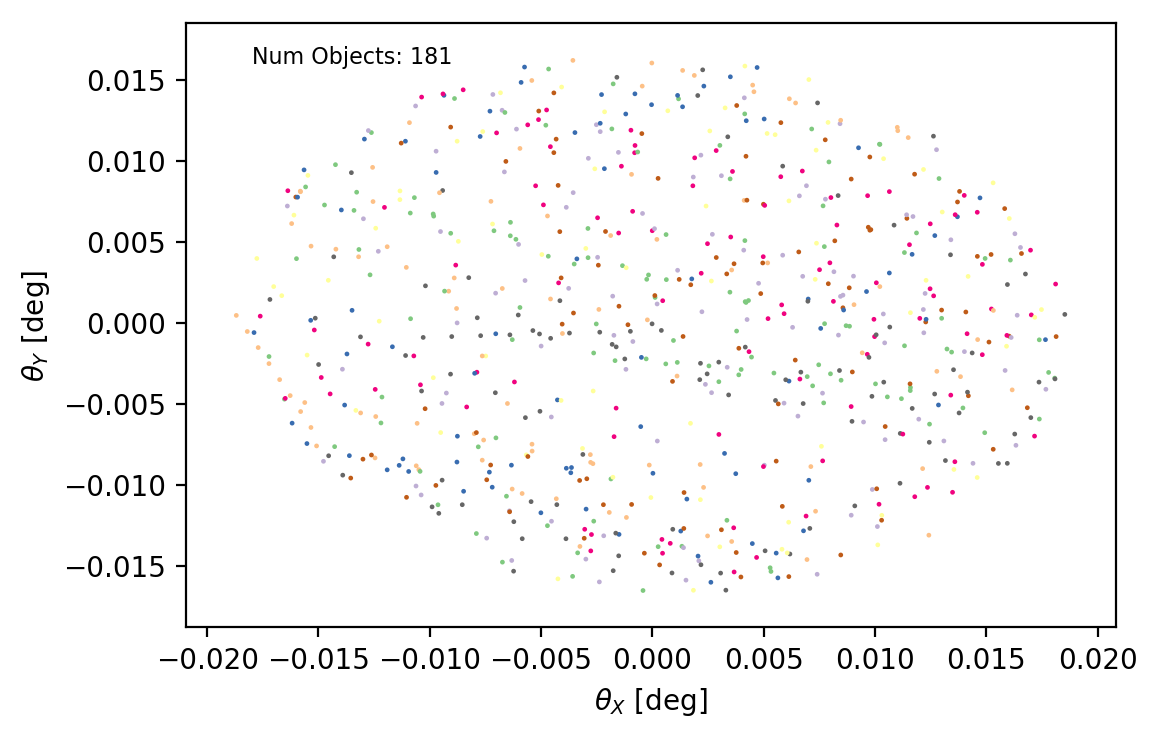

In [128]:
df = pd.DataFrame()
for c in cells3:
    c.observations["theta_x"] = c.gnomonic[:,0]
    c.observations["theta_y"] = c.gnomonic[:,1]
    df = pd.concat([df, c.observations])
    
a, b = np.unique(df["name"].values, return_inverse=True)
hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())

fig, ax = plt.subplots(1, 1, dpi=200)
ax = df.plot(x="theta_x", y="theta_y", kind="scatter", c=hex_map[b], s=0.5, ax=ax)
_setAxes(ax, "gnomonic")
ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
fig.savefig("10dayphasefold_incorrect_r-05_correct_v_colorByObject.png")